# Goal-Conditioned Visual Inference from Partial Observation
This Colab notebook demonstrates a simulation of the half-cycle right inference framework for visual scene completion, as described in the theorem on breaking the curse of dimensionality. The model attempts to reconstruct a high-dimensional image from partial observations using a structured latent hypothesis and amortized inference.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load a sample image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/640px-Golde33443.jpg'
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image = transform(img).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# Mask a portion (simulate partial observation)
mask = torch.ones_like(image)
mask[:, :, 64:192, 64:192] = 0
partial_image = image * mask

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 64 * 64, z_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Linear(z_dim, 128 * 64 * 64)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        x = self.fc(z).view(-1, 128, 64, 64)
        return self.deconv(x)

In [4]:
z_dim = 64
encoder = Encoder(z_dim).to(device)
decoder = Decoder(z_dim).to(device)

# Use fixed latent Φ and generate prediction
phi = torch.randn((1, z_dim)).to(device).requires_grad_(True)
optimizer = torch.optim.Adam([phi], lr=0.05)

for i in range(100):
    z = phi  # p(Z | Φ)
    recon = decoder(z)
    loss = F.mse_loss(recon * mask, partial_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Reconstruction loss after refinement: {loss.item():.4f}')

Reconstruction loss after refinement: 0.0904


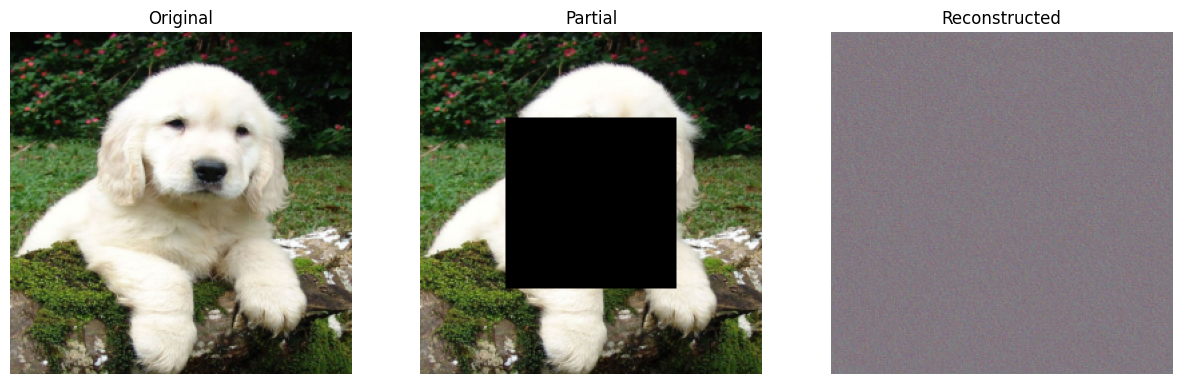

In [6]:
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(np.transpose(img.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

show_images([image, partial_image, recon], ['Original', 'Partial', 'Reconstructed'])